In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import least_squares, minimize
from sklearn import linear_model
import random

In [2]:
def f(tc, t, beta):
    return (tc-t)**beta
def g(tc, t, beta, omega):
    return f(tc, t, beta)*np.cos(omega*np.log(tc-t))
def h(tc, t, beta, omega):
    return f(tc, t, beta)*np.sin(omega*np.log(tc-t))

In [3]:
def LPPL(t, A, B, C1, C2, beta, omega, tc):
    return A + B*f(tc, t, beta) + C1*g(tc, t, beta, omega) + C2*h(tc, t, beta, omega)

In [4]:
def fit_ABC(beta, omega, tc, log_price):
    one_col = np.ones(len(log_price))

    t = np.arange(1,len(log_price)+1)
    f_col = f(tc=tc, t=t, beta=beta)
    g_col = g(tc=tc, t=t, beta=beta, omega=omega)
    h_col = h(tc=tc, t=t, beta=beta, omega=omega)

    X = np.array([one_col,f_col,g_col,h_col]).T
    A, B, C1, C2 = np.linalg.lstsq(X, log_price, rcond=None)[0]
    return {"A":A, "B":B, "C1":C1, "C2":C2}

In [ ]:
"""def f_min( beta, omega, tc, log_price):
    t = np.arange(1,len(log_price)+1)
    A, B, C1, C2 = fit_ABC(beta=beta, omega=omega, tc=tc, log_price=log_price)
    return LPPL(t, A, B, C1, C2, beta, omega, tc) - log_price"""

In [18]:
def opti_config(log_price):
    beta_0 = 0.5
    omega_0 = 9

    beta_m = 0.1 
    omega_m = 6

    beta_M = 0.9
    omega_M = 13

    tc_0 = len(log_price) + 15
    t_first = 0
    t_last = len(log_price)
    t_delta = t_last - t_first
    pct_delta_min = t_delta * 0.2
    pct_delta_max = t_delta * 2
    tc_m = t_last - pct_delta_min
    tc_M = t_last + pct_delta_max

    return {"beta_0":beta_0, "omega_0":omega_0, "tc_0":tc_0, "beta_m":beta_m, "omega_m":omega_m, "tc_m":tc_m, "beta_M":beta_M, "omega_M":omega_M, "tc_M":tc_M}

In [ ]:
"""def fit_LPPL(log_price):

    beta_0, omega_0, tc_0, beta_m, omega_m, tc_m, beta_M, omega_M, tc_M = opti_config(log_price)

    sol = least_squares(
        lambda x: f_min(beta=x[0], omega=x[1], tc=x[2], log_price=log_price),
        np.array([beta_0, omega_0,  tc_0]),
        bounds = ([beta_m, omega_m, tc_m], [beta_M, omega_M, tc_M])
    )

    if sol.success:
        beta, omega, tc = sol.x
        A, B, C1, C2 = fit_ABC(beta, omega, tc, log_price)
        sol.x = np.append(sol.x,[A, B, C1, C2])
    else:
        print("OLS failed.")
        sol.x = np.append(sol.x,np.zeros(4))
    return sol"""

In [6]:
def func_restricted(x, *args):
    '''
    finds the least square difference
    '''
    tc = x[0]
    beta = x[1]
    omega = x[2]

    log_price = args[0]
    # print('shape: {}'.format(obs.shape))

    fit = fit_ABC(beta, omega, tc, log_price)

    t = np.arange(len(log_price))
    delta = LPPL(t=t, A=fit['A'], B=fit['B'], C1=fit['C1'], C2=fit['C2'], beta=beta, omega=omega, tc=tc)-log_price
    delta = np.power(delta, 2)

    return np.sum(delta)

In [7]:
def fit(log_price, max_searches=25, minimizer='Nelder-Mead'):
    config = opti_config(log_price)

    search_count = 0
    # find bubble
    while search_count < max_searches:

        # set random initialization limits for non-linear params
        init_limits = [
            (config['tc_m'], config['tc_M']),  # tc : Critical Time
            (config['beta_m'], config['beta_M']),                  # m : 0.1 ≤ m ≤ 0.9
            (config['omega_m'], config['omega_M']),                     # ω : 6 ≤ ω ≤ 13
        ]

        # randomly choose vals within bounds for non-linear params
        non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]

        tc = non_lin_vals[0]
        beta = non_lin_vals[1]
        omega = non_lin_vals[2]

        seed = np.array([tc, beta, omega])

        try:
            cofs = minimize(
                args=log_price,
                fun=func_restricted,
                method=minimizer,
                x0=seed
            )

            if cofs.success:

                tc = cofs.x[0]
                beta = cofs.x[1]
                omega = cofs.x[2]

                # calculate the linear vals again...
                fit = fit_ABC(beta, omega, tc, log_price)
                normed_residual = func_restricted(cofs.x, log_price)/(7+len(log_price))
                # @TODO save these as variables local to the class so you can access them again
                return {'tc':tc, 'beta':beta, 'omega':omega, 'A':fit['A'], 'B':fit['B'], 'C1':fit['C1'], 'C2':fit['C2'],'Res':normed_residual}

            else:
                search_count += 1
        except Exception as e:
            print('minimize failed (' + str(search_count) + '/' + str(max_searches)+ '): {}'.format(e))
            search_count += 1
    return  {'tc':0, 'beta':0, 'omega':0, 'A':0, 'B':0, 'C1':0, 'C2':0,'Res':0}

In [8]:
def total_return(log_price):
    price = np.array(np.exp(log_price))
    return (price[-1]-price[0])/price[0]

In [9]:
def get_dt_max(sols, time_windows):
    residuals = [sol['Res'] for sol in sols]
    residuals_lgrn = obtainLagrangeRegularizedNormedCost(residuals, time_windows)
    return time_windows[np.argmin(residuals_lgrn)]


def obtainLagrangeRegularizedNormedCost(residuals, time_windows):
    slope = LagrangeMethod(residuals, time_windows)
    residuals_lgrn = residuals - slope*np.array(list(time_windows))
    return residuals_lgrn

def LagrangeMethod(residuals, time_windows):
    slope = calculate_slope_of_normed_cost(residuals, time_windows)
    return slope[0]

def calculate_slope_of_normed_cost(residuals, time_windows):
    regr =linear_model.LinearRegression(fit_intercept=False)
    x_residuals = np.array(list(time_windows))
    x_residuals = x_residuals.reshape(len(residuals),1)
    res = regr.fit(x_residuals, residuals)
    return res.coef_

In [10]:
def conditions_satisfied(beta, omega, tc, A, B, C1, C2, dt):
    c1 = 0.01 < beta < 1.2
    c2 = 2 < omega < 25
    c3 = 0.95*dt < tc < 1.11*dt
    c4 = 2.5 < omega/(2*np.pi)*np.log(abs(tc/(tc-dt)))
    C = C1/np.cos(np.arctan(C2/C1))
    c5 = 0.8 < beta * abs(B) / (omega * abs(C))
    return c1 and c2 and c3 and c4 and c5 

In [11]:
def LPPL_confidence(log_price, time_windows):
    
    sols = []
    for dt in time_windows:
        sols.append(fit(log_price[-dt:]))

    dt_max = get_dt_max(sols, time_windows)
    LPPL_confidences = []
    total_returns = []
    for dt in time_windows:
        sol = sols.pop(0)
        if dt <= dt_max and conditions_satisfied(beta=sol['beta'], omega=sol['omega'], tc=sol['tc'], A=sol['A'], B=sol['B'], C1=sol['C1'], C2=sol['C2'], dt=dt):
            LPPL_confidences.append(1)
            total_returns.append(total_return(log_price[-dt:]))

    return np.mean(LPPL_confidences)*np.sign(np.median(total_returns))


In [12]:
def LPPL_confidence_signal(log_price, time, time_windows):
    
    LPPL_confidence_ts = []
    for t2 in time:
        LPPL_confidence_ts.append(LPPL_confidence(log_price=log_price[:t2], time_windows=time_windows))
    return pd.DataFrame(LPPL_confidence_ts,index=log_price[time].index).fillna(0)

In [ ]:
short_dt = range(30,35)
medium_dt = range(91,300)
long_dt = range(301,750)

price = pd.read_csv("data.csv")["Closing Price (USD)"]
log_price = np.log(price)

LPPL_conf_ts = LPPL_confidence_signal(log_price, time=range(1500,1550), time_windows=np.linspace(50,10,50,dtype=int))

In [ ]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
ticker = '^GSPC'

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '1981-01-01'
end_date = '1987-08-30'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
price = panel_data['Adj Close']
log_price = np.log(price)



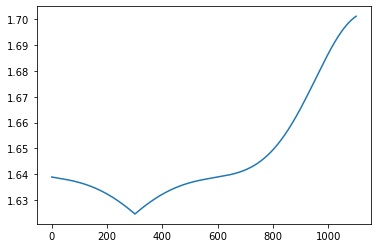

In [27]:
beta = 0.44
omega = 6.5
C1 = - 0.0001
C2 = 0.0005
A = 1.8259
B = - 0.0094
tc = 1194
log_price = LPPL(t=np.arange(800), A=A, B=B, C1=C1, C2=C2, beta=beta, omega=omega, tc=tc)
log_price = np.append(log_price[300::-1],log_price)
plt.plot(log_price)

In [19]:
fit(log_price[-600:])

{'tc': 694.4410949675702,
 'beta': 0.43974938978826034,
 'omega': 6.508977389311978,
 'A': 1.825699541832086,
 'B': -0.009404450549810064,
 'C1': -0.00012109138560043964,
 'C2': 0.0004962125891484621,
 'Res': 3.643789228497923e-08}

In [28]:
sols = []
time_windows = np.linspace(1100,30,1170,dtype=int)
for dt in time_windows:
    sols.append(fit(log_price[-dt:]))

dt_max = get_dt_max(sols, time_windows)

e in Linear Least Squares
minimize failed (7/25): SVD did not converge in Linear Least Squares
minimize failed (8/25): SVD did not converge in Linear Least Squares
minimize failed (9/25): SVD did not converge in Linear Least Squares
minimize failed (10/25): SVD did not converge in Linear Least Squares
minimize failed (0/25): SVD did not converge in Linear Least Squares
minimize failed (1/25): SVD did not converge in Linear Least Squares
minimize failed (2/25): SVD did not converge in Linear Least Squares
minimize failed (3/25): SVD did not converge in Linear Least Squares
minimize failed (4/25): SVD did not converge in Linear Least Squares
minimize failed (5/25): SVD did not converge in Linear Least Squares
minimize failed (6/25): SVD did not converge in Linear Least Squares
minimize failed (7/25): SVD did not converge in Linear Least Squares
minimize failed (8/25): SVD did not converge in Linear Least Squares
minimize failed (9/25): SVD did not converge in Linear Least Squares
minimiz

In [29]:
dt_max

1094

In [ ]:
beta = 0.44
omega = 6.5
C1 = - 0.0001
C2 = 0.0005
A = 1.8259
B = - 0.0094
tc = 1194
log_price = LPPL(np.arange(800), A, B, C1, C2, beta, omega, tc)
tc, beta, omega, A, B, C1, C2 = fit(log_price, 25)
plt.plot(LPPL(np.arange(len(log_price)), A, B, C1, C2, beta, omega, tc))
plt.plot(log_price)

In [ ]:
sol=fit(log_price, 25)

In [ ]:
tc, beta, omega, A, B, C1, C2=sol

In [ ]:
func_restricted(np.array([tc,beta,omega]), log_price)